In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, sys

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AiSoME 2023/train_val.csv")

In [ ]:
data.head(10)

,ID,tweet,labels
0,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"@PaolaQP1231 Well, I mean congratulations Covi...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed
5,1361038049556140034t,@DailyMailUK 😕 I'm confused: 💉 WITH the vaccin...,ineffective mandatory
6,1365287445114322946t,We do not need any crazy twisted politician te...,political
7,1364157842022891520t,@AgreeT0D1sagree @Matteo30115900 @Femi_Sorry I...,mandatory
8,1413367208537989123t,Taking One for the Team #TeamCanada New Astra~...,side-effect
9,1405695355996426240t,Canadians who received AstraZeneca vaccine exc...,side-effect ineffective


In [ ]:
labels = []

for i in data['labels'].unique():
  labels.extend(i.split())

labels = list(dict.fromkeys(labels).keys())

In [ ]:
labels

['ingredients',
 'side-effect',
 'mandatory',
 'rushed',
 'ineffective',
 'political',
 'none',
 'conspiracy',
 'country',
 'pharma',
 'unnecessary',
 'religious']

In [ ]:
label_to_id = {label:id for id, label in enumerate(labels)}

In [ ]:
corr = np.zeros((len(labels), len(labels)))
pmi = np.zeros((len(labels), len(labels)))
for label_set in data['labels']:
  for label in label_set.split():
    for neighbour in label_set.split():
        corr[label_to_id[label],label_to_id[neighbour]] += 1

label_occ = corr.sum(axis=1)
corr = corr / corr.sum(axis=1).reshape(-1,1)

In [ ]:
label_occ

array([ 750., 4883., 1116., 2304., 2196.,  966.,  629.,  924.,  292.,
       1897., 1159.,  105.])

In [ ]:
import re

def find_all_usernames_by_count(list_of_strings):

  username_count_mapping = {}
  for string in list_of_strings:
    extracted_usernames = re.findall('@[A-Za-z0-9_]+', string)

    for userName in extracted_usernames:
      username_count_mapping[userName] = username_count_mapping.get(userName, 0) + 1

  return {k:v for (k,v) in sorted(username_count_mapping.items(), key=lambda item: -item[1])}

username_count = find_all_usernames_by_count(data['tweet'].tolist())

In [ ]:
!pip install emoji
!pip install transformers

In [ ]:
import emoji
def remove_emojis(text):
    return emoji.replace_emoji(text)

def remove_non_occurring_usernames(text):
  try:
    new_text = [word for word in text.split() if not (word in username_count.keys()) or (username_count[word] >= 3)]
  except AttributeError as e:
    print(text)
  return ' '.join(new_text)

In [ ]:
data['tweet'] = data['tweet'].apply(lambda x: remove_emojis(x))
data['tweet'] = data['tweet'].apply(lambda x: remove_non_occurring_usernames(x))
data['tweet'] = data['tweet'].apply(lambda x: re.sub('https://\S+', '', x))
data['tweet'] = data['tweet'].apply(lambda x: re.sub('file://\S+', '', x))
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) <= 25]))

In [ ]:
data.head()

,ID,tweet,labels
0,1296010336907038720t,AstraZeneca is made with the kidney cells of a...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"Well, I mean congratulations Covid19 for being...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed


In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2)

In [ ]:
from transformers import AutoTokenizer, DebertaModel

# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
# model = DebertaModel.from_pretrained("microsoft/deberta-base")

# last_hidden_states = outputs.last_hidden_state

In [ ]:
# model.config

In [ ]:
# inputs['input_ids']

In [ ]:
# outputs.last_hidden_state[:,1:-1,:].size()

In [ ]:
import copy

class CustomDataset(Dataset):

  def __init__(self, data):
    self.data = data
    self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    tweet = self.data.iloc[idx]['tweet']
    labels = self.data.iloc[idx]['labels']

    labels = [label_to_id[label_name] for label_name in labels.split()]

    return (tweet, labels, len(labels))


def data_collate_fn(data):
  tweet, labels, label_lengths = zip(*data)

  max_label_length = max(label_lengths)
  batch_sz = len(labels)

  length_normalised_label_list = []
  label_matrix = torch.zeros((batch_sz, 12))

  for label in labels:
    last_label = label[-1]

    copy_label = copy.deepcopy(label)

    copy_label.extend([last_label] * (max_label_length - len(label)))
    length_normalised_label_list.append(copy_label)

  label_matrix = label_matrix.scatter_(dim=1, index = torch.tensor(length_normalised_label_list), src = torch.ones((batch_sz, max_label_length)))

  tweet = train_dataset.tokenizer(tweet, return_tensors = 'pt', padding=True, truncation=True)

  return {'tokenzed_ids': tweet, 'labels': label_matrix}

BATCH_SZ = 8
train_dataset = CustomDataset(data)
val_dataset = CustomDataset(val)
train_dataloader = DataLoader(train_dataset, collate_fn = data_collate_fn, shuffle = True, batch_size = BATCH_SZ)
val_dataloader = DataLoader(val_dataset, collate_fn = data_collate_fn, shuffle = True, batch_size = BATCH_SZ)


In [ ]:
class TweetClassificationModel(nn.Module):

  def __init__(self, num_classes: int):
    super(TweetClassificationModel, self).__init__()

    self.num_classes = num_classes
    self.deberta = DebertaModel.from_pretrained("microsoft/deberta-base")
    self.classwise_projs = nn.ModuleList([nn.Sequential(nn.LayerNorm(768, elementwise_affine  = True), nn.Linear(768, 1, bias = False)) for _ in range(self.num_classes)])

  def forward(self, X):
    outputs = self.deberta(**X)
    pooled_outputs, _ = torch.max(outputs.last_hidden_state[:,1:-1,:], dim = 1, keepdim = False) # max_pool while eliminating [CLS] and [SEP] tokens
    # pooled_outputs = [batch_sz, 768]

    classwise_probs = torch.cat([classwise_proj(pooled_outputs) for classwise_proj in self.classwise_projs], dim=-1)
    # classwise_probs = [batch_sz, 12] , where num_classes = 12

    return F.sigmoid(classwise_probs)

  def loss(self, preds, labels):
    __gamma = 2
    __eps = 1e-5

    focal_loss = ((labels - preds) ** __gamma) * (torch.log2(torch.abs(1. - labels - preds) + __eps))
    return -focal_loss.mean()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
myModel = TweetClassificationModel(num_classes = 12).to(device)

optimizer = torch.optim.Adam(myModel.parameters(), lr = 2e-4, eps=1e-08, betas=(0.5, 0.9))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience= 5)

optimizer.zero_grad()

print("Total trainable parameters: {params}".format(params = sum([p.numel() for name, p in myModel.named_parameters()])))

Total trainable parameters: 138629376


In [ ]:
import tqdm

EPOCHS = 4
train_steps = 0
LOSS = []
VAL_LOSS = []

grdient_accumulation_steps = 16

train_loss  = 0
for n_epoch in tqdm.tqdm(range(EPOCHS)):

    myModel.train()
    for i,X in enumerate(train_dataloader):
        train_steps += 1
        tweet, label_matrix = X['tokenzed_ids'].to(device), X['labels'].to(device)

        classwise_probs = myModel(tweet)

        loss = myModel.loss(classwise_probs, label_matrix)

        loss.backward()

        if train_steps % grdient_accumulation_steps == 0:
          optimizer.step()
          optimizer.zero_grad()
          # train_loss = 0

        train_loss += loss.item()

        if train_steps%60 == 0:

            with torch.no_grad():
                myModel.eval()
                val_loss = 0
                for i,X in enumerate(val_dataloader):

                    tweet, label_matrix = X['tokenzed_ids'].to(device), X['labels'].to(device)

                    classwise_probs = myModel(tweet)

                    loss = myModel.loss(classwise_probs, label_matrix)

                    val_loss += loss.item()

                scheduler.step(val_loss)

            scheduler.step(train_loss)

            LOSS.append(train_loss/train_steps)
            VAL_LOSS.append(val_loss/len(val_dataloader))

            torch.cuda.empty_cache()

            print(f'Epoch: {n_epoch+1} | Steps: {train_steps} | Train_loss: {LOSS[-1]:0.4f}') # | Val_loss: {VAL_LOSS[-1]:0.4f}')
            train_loss = 0
            train_steps = 0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | Steps: 60 | Train_loss: 0.2137
Epoch: 1 | Steps: 60 | Train_loss: 0.1399
Epoch: 1 | Steps: 60 | Train_loss: 0.1242
Epoch: 1 | Steps: 60 | Train_loss: 0.1280
Epoch: 1 | Steps: 60 | Train_loss: 0.1163
Epoch: 1 | Steps: 60 | Train_loss: 0.1195
Epoch: 1 | Steps: 60 | Train_loss: 0.1094
Epoch: 1 | Steps: 60 | Train_loss: 0.1069
Epoch: 1 | Steps: 60 | Train_loss: 0.1062
Epoch: 1 | Steps: 60 | Train_loss: 0.1040
Epoch: 1 | Steps: 60 | Train_loss: 0.0987
Epoch: 1 | Steps: 60 | Train_loss: 0.0951
Epoch: 1 | Steps: 60 | Train_loss: 0.1126
Epoch: 1 | Steps: 60 | Train_loss: 0.0988
Epoch: 1 | Steps: 60 | Train_loss: 0.0880
Epoch: 1 | Steps: 60 | Train_loss: 0.0785
Epoch: 1 | Steps: 60 | Train_loss: 0.0876
Epoch: 1 | Steps: 60 | Train_loss: 0.0825
Epoch: 1 | Steps: 60 | Train_loss: 0.0759
Epoch: 1 | Steps: 60 | Train_loss: 0.0785


 25%|██▌       | 1/4 [02:49<08:29, 169.97s/it]

Epoch: 2 | Steps: 60 | Train_loss: 0.0762
Epoch: 2 | Steps: 60 | Train_loss: 0.0704
Epoch: 2 | Steps: 60 | Train_loss: 0.0715
Epoch: 2 | Steps: 60 | Train_loss: 0.0622
Epoch: 2 | Steps: 60 | Train_loss: 0.0644
Epoch: 2 | Steps: 60 | Train_loss: 0.0667
Epoch: 2 | Steps: 60 | Train_loss: 0.0620
Epoch: 2 | Steps: 60 | Train_loss: 0.0654
Epoch: 2 | Steps: 60 | Train_loss: 0.0689
Epoch: 2 | Steps: 60 | Train_loss: 0.0690
Epoch: 2 | Steps: 60 | Train_loss: 0.0620
Epoch: 2 | Steps: 60 | Train_loss: 0.0596
Epoch: 2 | Steps: 60 | Train_loss: 0.0622
Epoch: 2 | Steps: 60 | Train_loss: 0.0620
Epoch: 2 | Steps: 60 | Train_loss: 0.0627
Epoch: 2 | Steps: 60 | Train_loss: 0.0626
Epoch: 2 | Steps: 60 | Train_loss: 0.0646
Epoch: 2 | Steps: 60 | Train_loss: 0.0551
Epoch: 2 | Steps: 60 | Train_loss: 0.0554
Epoch: 2 | Steps: 60 | Train_loss: 0.0550
Epoch: 2 | Steps: 60 | Train_loss: 0.0613


 50%|█████     | 2/4 [05:39<05:38, 169.42s/it]

Epoch: 3 | Steps: 60 | Train_loss: 0.0535
Epoch: 3 | Steps: 60 | Train_loss: 0.0512
Epoch: 3 | Steps: 60 | Train_loss: 0.0472
Epoch: 3 | Steps: 60 | Train_loss: 0.0504
Epoch: 3 | Steps: 60 | Train_loss: 0.0495
Epoch: 3 | Steps: 60 | Train_loss: 0.0454
Epoch: 3 | Steps: 60 | Train_loss: 0.0486
Epoch: 3 | Steps: 60 | Train_loss: 0.0457
Epoch: 3 | Steps: 60 | Train_loss: 0.0538
Epoch: 3 | Steps: 60 | Train_loss: 0.0491
Epoch: 3 | Steps: 60 | Train_loss: 0.0468
Epoch: 3 | Steps: 60 | Train_loss: 0.0488
Epoch: 3 | Steps: 60 | Train_loss: 0.0429
Epoch: 3 | Steps: 60 | Train_loss: 0.0435
Epoch: 3 | Steps: 60 | Train_loss: 0.0500
Epoch: 3 | Steps: 60 | Train_loss: 0.0424
Epoch: 3 | Steps: 60 | Train_loss: 0.0407
Epoch: 3 | Steps: 60 | Train_loss: 0.0427
Epoch: 3 | Steps: 60 | Train_loss: 0.0425
Epoch: 3 | Steps: 60 | Train_loss: 0.0440
Epoch: 3 | Steps: 60 | Train_loss: 0.0422


 75%|███████▌  | 3/4 [08:28<02:49, 169.41s/it]

Epoch: 4 | Steps: 60 | Train_loss: 0.0356
Epoch: 4 | Steps: 60 | Train_loss: 0.0324
Epoch: 4 | Steps: 60 | Train_loss: 0.0344
Epoch: 4 | Steps: 60 | Train_loss: 0.0346
Epoch: 4 | Steps: 60 | Train_loss: 0.0337
Epoch: 4 | Steps: 60 | Train_loss: 0.0330
Epoch: 4 | Steps: 60 | Train_loss: 0.0312
Epoch: 4 | Steps: 60 | Train_loss: 0.0321
Epoch: 4 | Steps: 60 | Train_loss: 0.0305
Epoch: 4 | Steps: 60 | Train_loss: 0.0351
Epoch: 4 | Steps: 60 | Train_loss: 0.0304
Epoch: 4 | Steps: 60 | Train_loss: 0.0317
Epoch: 4 | Steps: 60 | Train_loss: 0.0260
Epoch: 4 | Steps: 60 | Train_loss: 0.0293
Epoch: 4 | Steps: 60 | Train_loss: 0.0331
Epoch: 4 | Steps: 60 | Train_loss: 0.0335
Epoch: 4 | Steps: 60 | Train_loss: 0.0329
Epoch: 4 | Steps: 60 | Train_loss: 0.0322
Epoch: 4 | Steps: 60 | Train_loss: 0.0341
Epoch: 4 | Steps: 60 | Train_loss: 0.0338


100%|██████████| 4/4 [11:17<00:00, 169.30s/it]


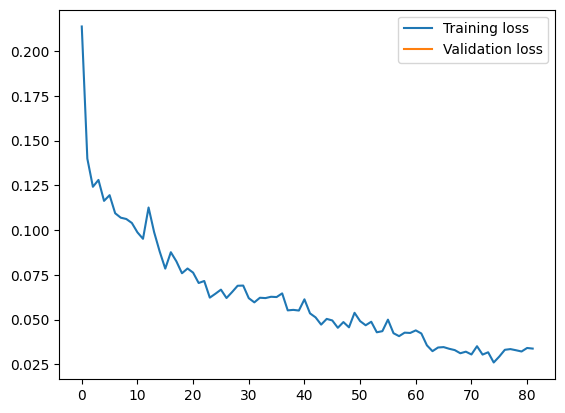

In [ ]:
plt.plot(LOSS, label = "Training loss")
# plt.plot(VAL_LOSS, label = "Validation loss")
plt.legend()
plt.show()

INFERENCE

In [ ]:
def inference():

  predictedLabels = []
  originalLabels = []

  myModel.eval()
  with torch.no_grad():

    for i,X in enumerate(val_dataloader):
      tweet, label_matrix = X['tokenzed_ids'].to(device), X['labels'].to(device)

      batch_sz = tweet['input_ids'].size(0)

      temp = [[] for i in range(batch_sz)]

      classwise_probs= myModel(tweet)

      classwise_probs = classwise_probs.detach().cpu()

      (r, c) = torch.where(classwise_probs > 0.5)

      r, c = r.tolist(), c.tolist()

      for index, class_id in zip(r,c):
        temp[index].append(class_id)

      predictedLabels.extend(temp)

      (r, c) = torch.where(label_matrix == 1.)

      r, c = r.tolist(), c.tolist()

      temp = [[] for i in range(batch_sz)]
      for index, class_id in zip(r,c):
        temp[index].append(class_id)

      originalLabels.extend(temp)

  return predictedLabels, originalLabels

In [ ]:
a,b = inference()

In [ ]:
confusion_matrix = np.zeros((12,12))
for i,j in zip(a,b):
  for pred, label in zip(i,j):
    confusion_matrix[label, pred] += 1

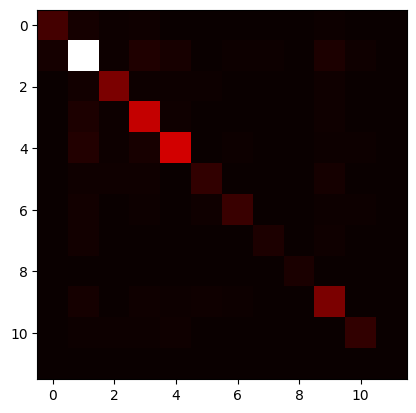

In [ ]:
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
Acc = sum([confusion_matrix[i][i] for i in range(12)]) / confusion_matrix.sum()

In [ ]:
Acc

0.7883087400681045

In [ ]:
confusion_matrix

array([[ 55.,  12.,   3.,   5.,   2.,   0.,   0.,   0.,   0.,   4.,   1.,
          0.],
       [ 12., 615.,   3.,  21.,  14.,   0.,   4.,   3.,   0.,  17.,   6.,
          0.],
       [  0.,   8., 104.,   3.,   4.,   4.,   1.,   1.,   0.,   5.,   2.,
          0.],
       [  1.,  17.,   4., 171.,   7.,   1.,   1.,   2.,   1.,   6.,   0.,
          0.],
       [  2.,  22.,   4.,  14., 184.,   2.,   3.,   1.,   0.,   4.,   3.,
          0.],
       [  1.,   5.,   5.,   7.,   2.,  37.,   0.,   2.,   2.,  10.,   0.,
          0.],
       [  0.,   8.,   1.,   3.,   1.,   5.,  45.,   0.,   0.,   3.,   4.,
          0.],
       [  0.,   8.,   0.,   2.,   1.,   2.,   0.,  19.,   0.,   7.,   0.,
          0.],
       [  0.,   2.,   0.,   1.,   0.,   1.,   1.,   0.,  16.,   0.,   0.,
          0.],
       [  0.,  11.,   1.,   6.,   4.,   5.,   4.,   2.,   0., 105.,   2.,
          0.],
       [  0.,   4.,   3.,   4.,   7.,   1.,   0.,   1.,   0.,   2.,  37.,
          0.],
       [  0.,   1.,  

Test Data Evaluation

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/aisome23_test/test.csv")

In [ ]:
test['tweet'] = test['tweet'].apply(lambda x: remove_emojis(x))
test['tweet'] = test['tweet'].apply(lambda x: remove_non_occurring_usernames(x))
test['tweet'] = test['tweet'].apply(lambda x: re.sub('https://\S+', '', x))
test['tweet'] = test['tweet'].apply(lambda x: re.sub('file://\S+', '', x))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) <= 25]))

In [ ]:
result_ids = []
result_labels = []

for row in test.iterrows():
  _id = row[1]['id']
  tweet = row[1]['tweet']

  tweet = train_dataset.tokenizer([tweet], return_tensors = 'pt', padding=True, truncation=True).to(device)

  predicted_probs = myModel(tweet)

  predicted_probs = predicted_probs.detach().cpu().numpy()

  predicted_classes = np.where(predicted_probs >= 0.5)[1].tolist()

  predicted_classes = [labels[i] for i in predicted_classes]

  result_ids.append(_id)
  result_labels.append(' '.join(predicted_classes))
  # break

In [ ]:
result_ids, result_labels

(['1070378532260470789t'], ['side-effect mandatory'])

In [ ]:
D = pd.DataFrame({"id": result_ids, "pred_classes": result_labels})
D.to_csv("/content/aisome_test_preds.csv", index = False)